# Assignment 4

In this assignment, you will be training an agent to play Lunar Lander using Deep Q Learning. Fill the code where asked and wherever "pass" is written

# Description

This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

## Action Space

There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

## Observation Space

There are 8 states: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

## Reward

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

## Termination

The episode finishes if:

1. the lander crashes (the lander body gets in contact with the moon);
2. the lander gets outside of the viewport (x coordinate is greater than 1);

In [1]:
!pip install box2d-py
!pip install gym==0.24.0
#Restart runtime after running this cell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 14.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 694 kB 16.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.24.0-py3-none-any.whl size=790705 sha256=60ee1d0a16914ab84733773ff463bcdfa77fc7c6730f1e255c8fbfccbdb95dd5
  Stored in directory: /root/.cache/pip/wheels/68/7a/27/ac44ac6e4763637d0ed8d89f686465960f9837440ee880abe6
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [2]:
import numpy as np
import gym
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import time
import matplotlib.pyplot as plt

## Environment variables

gravity dictates the gravitational constant, this is bounded to be within 0 and -12.

If enable_wind=True is passed, there will be wind effects applied to the lander. The wind is generated using the function tanh(sin(2 k (t+C)) + sin(pi k (t+C))). k is set to 0.01. C is sampled randomly between -9999 and 9999.

wind_power dictates the maximum magnitude of linear wind applied to the craft. The recommended value for wind_power is between 0.0 and 20.0. turbulence_power dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for turbulence_power is between 0.0 and 2.0.

In [3]:
#Set the parameters for your environment
env = gym.make("LunarLander-v2", gravity = -5.0, enable_wind = True, wind_power = 15.0, turbulence_power = 1.9999) 

In [80]:
#Define your Q-Network
class Q_Network(nn.Module):
    def __init__(self, state_dim , action_dim):
        super(Q_Network, self).__init__()
        ## Define a neural network with the following architecture: (Feel Free to experiment)
        # 1. Input layer 
        # 2. Hidden Layer 1 with 150 units
        # 3. Hidden Layer 2 with 120 units 
        # 4. Output layer 
        self.fc1=nn.Linear(in_features=state_dim,out_features=150)
        self.fc2=nn.Linear(in_features=150,out_features=120)
        self.fc3=nn.Linear(in_features=120,out_features=action_dim)

    def forward(self, state):
        t = F.relu(self.fc1(state)) #Apply relu activation on output of input layer
        t = F.relu(self.fc2(t)) #Apply relu activation on output of first hidden layer
        state_action_values = t #No activation required for final output
        return self.fc3(state_action_values)

In [81]:
#Implement Replay Memory
class ReplayBuffer(object):
    def __init__(self):
        self.buffer = []
        
    def add_to_buffer(self, data): #Function to add to buffer
        #Data must be of the form (state,next_state,action,reward,terminal)
        #Append data to the buffer list
        data=(state,next_state,[action],[reward],[terminal])
        self.buffer.append(data)

    def sample_minibatch(self,num_samples): #Function to sample from buffer memory
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for i in range(num_samples):
            ## Sample num_samples replays from buffer, and store the observed experiences in their respective variables
            # Hint: To sample, generate a random integer (make sure its in valid range) and use it as index
            ## Your Code Here ##
            k=random.randrange(num_samples)

            #####################
            states.append(self.buffer[k][0])
            next_states.append(self.buffer[k][1])
            actions.append(self.buffer[k][2])
            rewards.append(self.buffer[k][3])
            terminals.append(self.buffer[k][4])
        return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(rewards), torch.Tensor(terminals)


In [185]:
#Define your Deep Q Network Agent
class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = Q_Network(state_dim, action_dim)
        self.qnet_optim = torch.optim.Adam(self.qnet.parameters(), lr=0.105) #Set an appropriate learning rate
        self.discount_factor = 0.999 #Set an appropriate discount factor
        self.MSELoss_function = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()
       
    
    def act(self, state, epsilon): 
        # Implement epsilon greedy strategy 
        ## Your Code Here ##
        if random.random() > epsilon:
          state = torch.from_numpy(state).float().unsqueeze(0)
          self.qnet.eval()
          with torch.no_grad():
            action_values = self.qnet(state)
          return np.argmax(action_values).data.numpy()
        else:
            return random.choice(np.arange(self.action_dim))
        ####################
        

    def update_Q_Network(self, state, next_state, action, reward, terminals): #Update your Q-network
        
        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())
        qsa_next_action = self.qnet(next_state)
        qsa_next_action,_ = torch.max(qsa_next_action, dim=1, keepdim=True)
        not_terminals = 1 - terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * qsa_next_action
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
        
    def update(self, update_rate=128):
        for i in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample_minibatch(64)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            self.update_Q_Network(states, next_states, actions, rewards, terminals)
    
    def best_move(self, state):
        ## Return the best move
        pass 

In [186]:
action_dim = 4 # Dimensions of action space
state_dim = 8 # Dimension of state space

In [187]:
agent = DQNAgent(state_dim, action_dim)
number_of_episodes = 600 #Number of episodes
max_time_steps = 10000 #Maximum time steps per episode
reward_list = []
epsilon = 1

### Train your agent
for episode in range(number_of_episodes):
    reward_sum = 0 #Reward for one episode
    state = env.reset()
    for _ in range(max_time_steps):
        # 1. Take an action using the epsilon greedy function (ensure you pass the state as a tensor)
        action = agent.act(state,epsilon)
        next_state, reward, terminal, _ = env.step(action) # Take the action and get the new state
        reward_sum += reward #Update the reward for episode
        agent.replay_buffer.add_to_buffer((state,next_state,[action],[reward],[terminal])) #Add experience to buffer
        state = next_state
        if terminal:
            clear_output(wait=True)
            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
            reward_list.append(reward_sum)
            break   
    agent.update() #Update the agent
    
    ##Update epsilon
    # if epislon >0.2, multiply it by 0.995, otherwise do not change it
    ## Your code here ##
    if epsilon>0.2:
      epsilon = epsilon*0.995
    ####################

episode: 599 sum_of_rewards_for_episode: -561.3668462997935


In [188]:
def moving_average(values, window=10): #Run this as it is
    weight = np.repeat(1.0, window)/window
    smas = np.convolve(values,weight,'valid')
    return smas
smas_ = moving_average(reward_list)

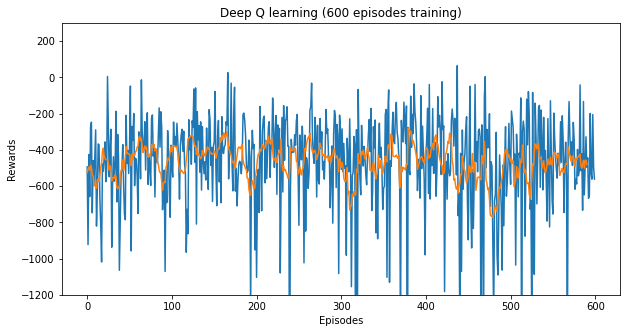

In [189]:
#Plot the rewards over episodes
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(reward_list)
ax.plot(smas_)
ax.set_ylim([-1200, 300])
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
ax.set_title('Deep Q learning (600 episodes training)')
plt.savefig('DQN600epma', transparent=True)